# AS - TP Modules Torch

Ce TP porte sur l'implémentation des modules de réseau de neurones en utilisant la librairie Torch. On utilisera le dataset MNIST pour l'expérimentation.

In [1]:
import numpy as np
import random
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.autograd import Function
from matplotlib import pyplot as plt

torch.Size([60000, 28, 28])


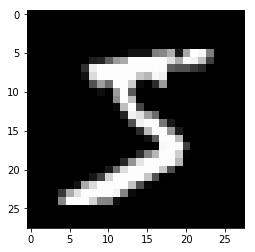

5


In [2]:
batch_size=64
nb_digits=10
train_loader = torch.utils.data.DataLoader(datasets.MNIST('./data', train=True, download=True, transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,),(0.3081,))])), batch_size=batch_size, shuffle=True) 
test_loader = torch.utils.data.DataLoader(datasets.MNIST('./data', train=False, download=True, transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,),(0.3081,))])), batch_size=batch_size, shuffle=True) 
print(train_loader.dataset.train_data.size())

y_onehot = torch.FloatTensor(batch_size, nb_digits) 

'''for i,(data, target) in enumerate(train_loader):
    #print(i ,data.size(), data.type(), target.size(), target.type()) 
    # do something...
    ## Encoding des labels en onehot
    y_onehot.zero_()
    y_onehot.scatter_(1, target.view(-1,1), 1)'''
    
plt.imshow(train_loader.dataset.train_data[0].numpy(), cmap="gray")
plt.show()
print(train_loader.dataset.train_labels[0])

On implémente les modules.

In [3]:
class FLinear(Function):
    def forward(self, x, theta):
        self.x = x
        self.theta = theta
        return x.mm(theta)
    
    def backward(self, delta, y_real=None):
        return delta.mm(self.theta.transpose(0, 1)), self.x.transpose(0, 1).mm(delta)

In [4]:
class FHTan(Function):
    def forward(self, x, theta=None):
        self.x = x
        return (torch.exp(x) - torch.exp(-x)) / (torch.exp(x) + torch.exp(-x))
    
    def backward(self, delta, y_real=None):
        x = self.x
        r = (1 - ((torch.exp(x) - torch.exp(-x)) / (torch.exp(x) + torch.exp(-x))) ** 2) * delta
        return r, r

In [5]:
class FSquareLoss(Function):
    def forward(self, y_predict, y_real):
        return torch.mean((y_predict - y_real) * (y_predict - y_real))
    
    def backward(self, y_predict, y_real):
        return 2. * (y_predict - y_real) / y_predict.size()[0], 2. * (y_real - y_predict) / y_predict.size()[0]

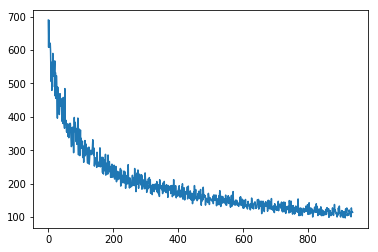

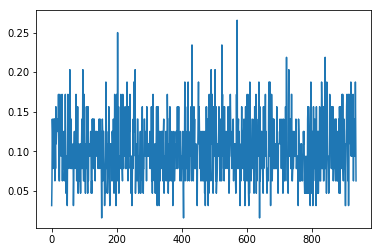

In [6]:
# Préparation des données

#x = train_loader.dataset.train_data.float().view(-1, 784)   # Applatissement des paramètres
#y = train_loader.dataset.train_labels.float()

features = 28*28

lin_theta = torch.randn(features, nb_digits)
#tan_theta = torch.randn(500)/100  #np.random.uniform(-0.01, 0.01) # initialisation 

linear = FLinear()
htan = FHTan()
loss = FSquareLoss()

iters = 1000
epsilon = 1e-4

errors = []
scores = []

for i, (data, target) in enumerate(train_loader):
    x = data.float().view(-1, features)
    y = torch.FloatTensor(target.size()[0], nb_digits).zero_().scatter_(1, target.view(-1, 1), 1)
    y_predict_1 = linear.forward(x, lin_theta)
    
    errors.append(loss.forward(y_predict_1, y))
    scores.append(np.sum([1 for ypi, yi in zip(y_predict_1, y) if ypi.max(0)[1].equal(yi.max(0)[1])])/batch_size)
    
    d_y_predict, d_y = loss.backward(y_predict_1, y)
    d_x, d_theta = linear.backward(d_y_predict)
    lin_theta -= epsilon*d_theta
    

plt.plot(errors)
plt.show()

plt.plot(scores)
plt.show()


In [7]:
class Calcul(object):
    def __init__(self):
        self.functions = []
        self.thetas = []
        self.epsilons = []
        
    def add(self, m, t=None, e=1e-4):
        '''Ajoute un module et son paramétrage (qui définit aussi la dimension de sortie)'''
        self.functions.append(m)
        self.thetas.append(t)
        self.epsilons.append(e)
        return self
    
    def test(self, x, y):
        l = len(self.functions)
        for i in range(l-1):
            f = self.functions[i]
            t = self.thetas[i]
            x = f.forward(x, t)                   # Forward
        return self.functions[-1].forward(x, y), torch.sum(torch.Tensor([1 for ypi, yi in zip(y_predict_1, y) if ypi.max(0)[1].equal(yi.max(0)[1])]))/y.size()[0]
        
    def run(self, x, y):
        '''Effectue un aller-retour sur la chaîne de modules.'''
        
        l = len(self.functions)
        error = 0
        score = 0
        
        # Propagation forward
        for i in range(l):
            f = self.functions[i]
            t = self.thetas[i]
            if i == l-1:
                y_predict = x                     # On conserve la prédiction finale avant le MSE
                t = y
            x = f.forward(x, t)                   # Forward
            
        # Evaluation
        error = x
        score = torch.sum(torch.Tensor([1 for ypi, yi in zip(y_predict_1, y) if ypi.max(0)[1].equal(yi.max(0)[1])]))/y.size()[0]
            
        # Propagation backward
        d_y_predict = y_predict
        for i in reversed(range(l)):
            f = self.functions[i]
            t = self.thetas[i]
            e = self.epsilons[i]
            d_y_predict, d_theta = f.backward(d_y_predict, y)
            if t is not None:
                self.thetas[i] -= e * d_theta         # Mise à jour des paramètres
            
        return error, score
        
                

In [8]:
features = 28*28
var = 1e-2

# Linéaire simple
linear = Calcul()
linear.add(FLinear(), torch.randn(features, nb_digits) * var)
linear.add(FSquareLoss())

# Linéaire + TanH
lintan = Calcul()
lintan.add(FLinear(), torch.randn(features, nb_digits) * var)
lintan.add(FHTan())
lintan.add(FSquareLoss())

# Linéaire + TanH double
double = Calcul()
double.add(FLinear(), torch.randn(features, 500) * var)
double.add(FHTan())
double.add(FLinear(), torch.randn(500, nb_digits) * var)
double.add(FHTan())
double.add(FSquareLoss())

# Variante triple
triple = Calcul()
triple.add(FLinear(), torch.randn(features, 2000) * var)
triple.add(FHTan())
triple.add(FLinear(), torch.randn(2000, 3000) * var)
triple.add(FHTan())
triple.add(FLinear(), torch.randn(3000, nb_digits) * var)
triple.add(FHTan())
triple.add(FSquareLoss())

modele = [linear, lintan, double, triple]
errors = [list(), list(), list(), list()]
scores = [list(), list(), list(), list()]
errorst = [list(), list(), list(), list()]
scorest = [list(), list(), list(), list()]

In [10]:
for i, (data, target) in enumerate(train_loader):
    
    # (Avec évaluation test, le process entier dure environ 5 à 10 minutes)
    #print("Itération", i+1)
    
    x = data.float().view(-1, features)
    y = torch.FloatTensor(target.size()[0], nb_digits).zero_().scatter_(1, target.view(-1, 1), 1)
    
    # Appretissage et évaluation train
    for i in range(4):
        e, s = modele[i].run(x, y)
        errors[i].append(e)
        scores[i].append(s)
        
    # Evaluation sur test
    for it, (datat, targett) in enumerate(test_loader):
        if it > 10:
            break
        xt = datat.float().view(-1, features)
        yt = torch.FloatTensor(targett.size()[0], nb_digits).zero_().scatter_(1, targett.view(-1, 1), 1)

        for i in range(4):
            e, s = modele[i].test(xt, yt)
            errorst[i].append(e)
            scorest[i].append(s)


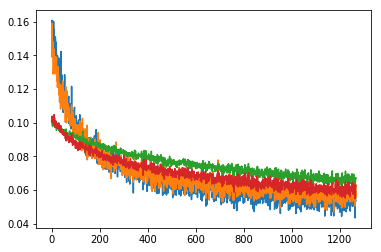

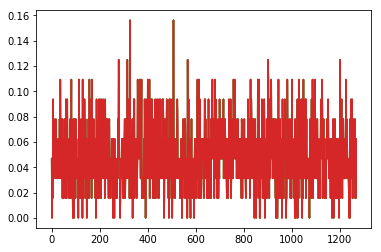

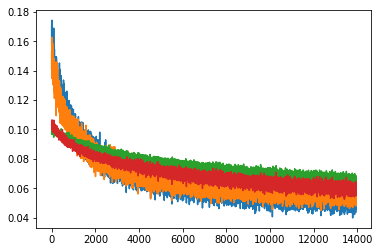

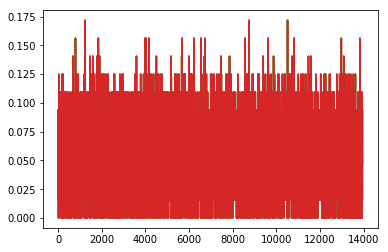

In [11]:
plt.plot(np.array(errors).T)
plt.show()
plt.plot(np.array(scores).T)
plt.show()
plt.plot(np.array(errorst).T)
plt.show()
plt.plot(np.array(scorest).T)
plt.show()

On constate que les réseaux complexes ont convergent plus lentement.